In [64]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("airbnb_colombia.sqlite")

df_metadata = pd.read_sql_query("SELECT * FROM MetadataInterpolada", conn)
df_fechas = pd.read_sql_query("SELECT * FROM FechasInterpoladas", conn)

conn.close()
columnas_metadata = [
    "ID",
    "Limpieza", "Veracidad", "Check-in", "Comunicación",
    "Ubicación", "Calidad", "Tarifa", "Cleaning",
    "Habs", "Jacuzzi", "Mean","Var"
]

df_metadata=df_metadata[[col for col in df_metadata.columns if col  in columnas_metadata]]
df_metadata['Jacuzzi'] = df_metadata['Jacuzzi'].map({"SI": 1, "NO": 0})

df_metadata.head()

,ID,Limpieza,Veracidad,Check-in,Comunicación,Ubicación,Calidad,Tarifa,Cleaning,Habs,Jacuzzi,Mean,Var
0,1,5.0,5.0,5.0,5.0,5.0,5.0,$79.00,$36.00,2,1,115.772388,7.831323
1,2,4.9,5.0,5.0,5.0,4.8,5.0,$95.00,$38.00,2,1,138.440299,136.770898
2,3,5.0,5.0,5.0,5.0,5.0,5.0,$100.00,$35.00,2,1,113.776119,6.880936
3,4,5.0,5.0,5.0,5.0,5.0,5.0,$67.00,$36.00,1,1,100.634328,67.275622
4,5,5.0,5.0,5.0,5.0,5.0,5.0,$81.00,$36.00,2,1,109.238806,50.961508


In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_metadata.select_dtypes(include=[np.number]).drop(columns=["ID"]))

# PCA automático: selecciona suficientes componentes para explicar >=80% varianza
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_scaled)

# Número de componentes seleccionados automáticamente
print(f"Número de componentes seleccionados: {pca.n_components_}")
print(f"Varianza explicada total: {pca.explained_variance_ratio_.sum():.4f}")


Número de componentes seleccionados: 6
Varianza explicada total: 0.8513


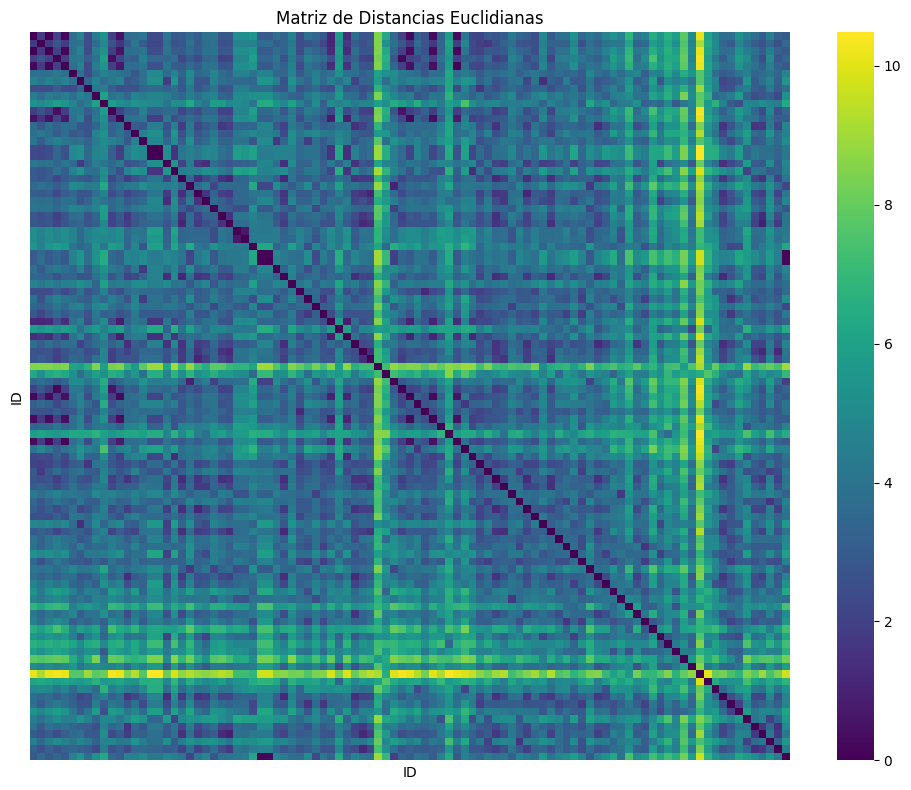

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

df_pca = df_metadata.copy()

columnas_usar = df_pca.select_dtypes(include=[np.number]).columns.difference(['ID'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca[columnas_usar])

pca = PCA(n_components=pca.n_components_)
X_pca = pca.fit_transform(X_scaled)

columnas_pca = [f"PC{i+1}" for i in range(pca.n_components_)]
df_pca_result = pd.DataFrame(X_pca, columns=columnas_pca)
df_pca_result["ID"] = df_pca["ID"].values

dist_matrix = squareform(pdist(X_scaled, metric='euclidean'))
df_dist = pd.DataFrame(dist_matrix, index=df_pca["ID"], columns=df_pca["ID"])
fig = px.scatter(
    df_pca_result,
    x="PC1",
    y="PC2",
    text="ID",  
    color="PC3",  
    title="PC1 vs PC2",
    width=800,
    height=600
)

fig.update_traces(textposition='top center')
fig.update_layout(margin=dict(l=20, r=20, b=20, t=50), template="plotly_white", showlegend=False)
fig.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df_dist, cmap="viridis", xticklabels=False, yticklabels=False)
plt.title("Matriz de Distancias Euclidianas")
plt.tight_layout()
plt.show()


In [79]:
import os
import os
from scipy.spatial.distance import pdist, squareform
from PIL import Image
points = df_pca_result[["PC1", "PC2", "ID"]].copy().reset_index(drop=True)
X = points[["PC1", "PC2"]].values
ids = points["ID"].astype(str).values

# Configuración
n_frames = 30
max_radius = 0.5  # Ajusta según escala de PC
frames = []

# Crear carpeta temporal para imágenes
os.makedirs("frames_tmp", exist_ok=True)

for frame_idx in range(n_frames):
    radius = max_radius * (frame_idx + 1) / n_frames
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    ax.set_ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

    # Dibujar círculos
    for i, (x, y) in enumerate(X):
        circle = plt.Circle((x, y), radius=radius, color='lightblue', alpha=0.3)
        ax.add_patch(circle)
        ax.text(x, y, ids[i], fontsize=8, ha='center', va='center')

    for i in range(len(X)):
        for j in range(i+1, len(X)):
            dist = np.linalg.norm(X[i] - X[j])
            if dist < 2 * radius:
                ax.plot([X[i][0], X[j][0]], [X[i][1], X[j][1]], 'b-', alpha=0.4)

    ax.set_title(f"Frame {frame_idx+1}")
    ax.axis('off')

    # Guardar imagen temporal
    filename = f"frames_tmp/frame_{frame_idx:03d}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    frames.append(Image.open(filename))
frames.append(Image.open(filename))

frames[0].save("nerves_colombia.gif", save_all=True, append_images=frames[1:], duration=100, loop=0)


In [84]:
!pip install gudhi --quiet



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\EdsonAlvarez\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [85]:
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt

# Usamos tus datos PCA 2D
points = df_pca_result[["PC1", "PC2", "ID"]].copy().reset_index(drop=True)
X = points[["PC1", "PC2"]].values

# Crear complejo de Vietoris-Rips con un máximo de distancia (ajusta según tus datos)
max_edge_length = 5.0  # Puedes ajustar este parámetro para incluir más conexiones

rips_complex = gd.RipsComplex(points=X, max_edge_length=max_edge_length)

# Construir la estructura simplicial con dimensión máxima 2
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

# Calcular la homología persistente
diag = simplex_tree.persistence()

# Mostrar el diagrama de persistencia
gd.plot_persistence_diagram(diag)
plt.title("Diagrama de Persistencia (PCA 2D)")
plt.show()


ModuleNotFoundError: No module named 'gudhi'

In [15]:
import pandas as pd
import sqlite3
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt

df_fechas["Date"] = pd.to_datetime(df_fechas["Date"])

# Filtrar solo entre mayo y agosto 2025
inicio = pd.to_datetime("2025-05-25")
fin = pd.to_datetime("2025-08-1")
df_fechas_filtrado = df_fechas[(df_fechas["Date"] >= inicio) & (df_fechas["Date"] <= fin)]

# Crear gráfico
fig = px.line(
    df_fechas_filtrado,
    x="Date",
    y="Value",
    color="ID",
    title="Valores por fecha (mayo a agosto 2025)"
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="ID"
)
fig.show(renderer="browser")



In [ ]:
from sklearn.preprocessing import PCA